In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# EDA & Data Cleaning

In [2]:
names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

In [3]:
df_train = pd.read_csv('data/adult_train.csv', names = names, index_col=False)
df_test = pd.read_csv('data/adult_test.csv', names = names, index_col=False)

In [4]:
df_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
print('training dataset size before cleaning: {}'.format(len(df_train)))
print('testing dataset size before cleaning: {}'.format(len(df_test)))

training dataset size before cleaning: 32561
testing dataset size before cleaning: 16282


In [6]:
df_train.replace(' ?', np.NaN, inplace = True)
df_train.dropna(inplace = True)
print('training dataset size before cleaning: {}'.format(len(df_train)))

df_test.replace(' ?', np.NaN, inplace = True)
df_test.dropna(inplace = True)
print('training dataset size before cleaning: {}'.format(len(df_test)))

training dataset size before cleaning: 30162
training dataset size before cleaning: 15060


In [7]:
df = pd.concat([df_train, df_test])

## Remove whitespace in front of string

In [8]:
string_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']
df[string_cols] = df[string_cols].apply(lambda x: x.str.strip())

## Check if the mapping between education and education-num is correct.

In [9]:
edu_pairs = [str(edu) + ' : '+ str(edu_num) for (edu, edu_num) in df[['education', 'education-num']].values]
np.unique(edu_pairs)

array(['10th : 6.0', '11th : 7.0', '12th : 8.0', '1st-4th : 2.0',
       '5th-6th : 3.0', '7th-8th : 4.0', '9th : 5.0', 'Assoc-acdm : 12.0',
       'Assoc-voc : 11.0', 'Bachelors : 13.0', 'Doctorate : 16.0',
       'HS-grad : 9.0', 'Masters : 14.0', 'Preschool : 1.0',
       'Prof-school : 15.0', 'Some-college : 10.0'], dtype='<U19')

Note that there's an order in the education-num. This varible will be used as a continuous variable while education variable will be dropped. 

In [10]:
numerical_cols = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

categorical_cols = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

In [11]:
df_dummies = pd.get_dummies(df[categorical_cols])
df_final = pd.concat([df[numerical_cols], df_dummies], axis = 1)
df_final.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,13.0,2174.0,0.0,40.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,13.0,0.0,0.0,13.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,38,9.0,0.0,0.0,40.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,7.0,0.0,0.0,40.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,13.0,0.0,0.0,40.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[categorical_cols])
array_dummies = enc.transform(df[categorical_cols]).toarray()
X = np.concatenate((df[numerical_cols].values, array_dummies), axis = 1)

In [13]:
np.save('one_hot_encoder.npy', enc)

In [14]:
target = df['income'].values
np.unique(target), np.unique(target)

(array(['<=50K', '<=50K.', '>50K', '>50K.'], dtype=object),
 array(['<=50K', '<=50K.', '>50K', '>50K.'], dtype=object))

In [15]:
target_dict = {'<=50K':0, '>50K':1, '<=50K.':0, '>50K.':1}
y = [target_dict[t] for t in target]

In [16]:
X_train = X[:len(df_train)]
X_test = X[len(df_train):]
y_train = y[:len(df_train)]
y_test = y[len(df_train):]

## Balance Dataset

Note that the dataset is imbalance. 

(array([22654.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  7508.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

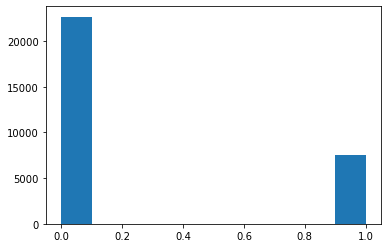

In [17]:
plt.hist(y_train)

(array([11360.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  3700.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

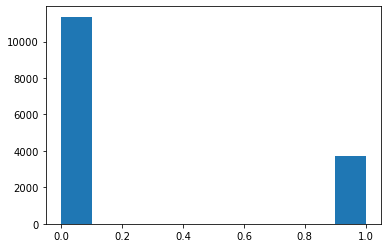

In [18]:
plt.hist(y_test)

Perform systmetic sampling to make training dataset more balance. 

In [19]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

# Model training

## Random Forest Classifier

In [41]:
clf = RandomForestClassifier(max_depth=20, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, random_state=0)

In [49]:
joblib.dump(clf, 'random_forest_clf')

['random_forest_clf']

In [22]:
y_pred = clf.predict(X_test)

In [23]:
def plot_confusion_matrix(y_true, y_pred, label_text, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    
    cm = pd.DataFrame(cm, index=label_text, columns=label_text)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [24]:
matrix = classification_report(y_test, y_pred)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.92      0.87      0.89     11360
           1       0.66      0.76      0.71      3700

    accuracy                           0.84     15060
   macro avg       0.79      0.82      0.80     15060
weighted avg       0.85      0.84      0.85     15060



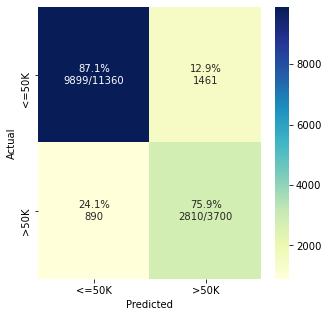

In [25]:
label_text = ['<=50K', '>50K']
plot_confusion_matrix(y_test, y_pred, label_text)

## Gradient Boosting Classifier

In [26]:
clf = GradientBoostingClassifier(random_state=0)
clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [51]:
joblib.dump(clf, 'gradient_boosting_clf')

['gradient_boosting_clf']

In [28]:
y_pred = clf.predict(X_test)

In [29]:
matrix = classification_report(y_test, y_pred)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.92      0.87      0.89     11360
           1       0.66      0.77      0.71      3700

    accuracy                           0.84     15060
   macro avg       0.79      0.82      0.80     15060
weighted avg       0.86      0.84      0.85     15060



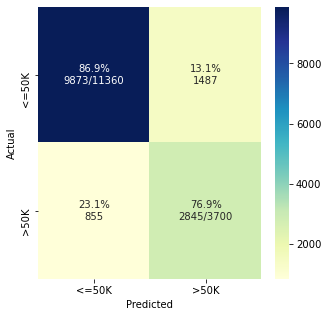

In [30]:
label_text = ['<=50K', '>50K']
plot_confusion_matrix(y_test, y_pred, label_text)

F-1 score of both models are extremenly close. It is possible to perform extensive grid search on both model to determine a better model. Here we choose the gradient boosted model 

In [60]:
for col in categorical_cols:
    print(df[col].unique())

['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' 'Without-pay']
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Transport-moving' 'Farming-fishing'
 'Machine-op-inspct' 'Tech-support' 'Craft-repair' 'Protective-serv'
 'Armed-Forces' 'Priv-house-serv']
['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']
['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
['Male' 'Female']
['United-States' 'Cuba' 'Jamaica' 'India' 'Mexico' 'Puerto-Rico'
 'Honduras' 'England' 'Canada' 'Germany' 'Iran' 'Philippines' 'Poland'
 'Columbia' 'Cambodia' 'Thailand' 'Ecuador' 'Laos' 'Taiwan' 'Haiti'
 'Portugal' 'Dominican-Republic' 'El-Salvador' 'France' 'Guatemala'
 'Italy' 'China' 'South' 'Japan' 'Yugoslavia' 'Peru'
 'Outlying-US(Guam-USVI-etc)' 'Scotland' 'Trinadad&Tobago' '